# About

Abstract: **DOROTHEA** is a drug discovery dataset. Chemical compounds represented by structural molecular features must be classified as active (binding to thrombin) or inactive. 
	

### Data Set Information:

[Source](https://archive.ics.uci.edu/ml/datasets/dorothea)

"Drugs are typically small organic molecules that achieve their desired activity by binding to a target site on a receptor. The first step in the discovery of a new drug is usually to identify and isolate the receptor to which it should bind, followed by testing many small molecules for their ability to bind to the target site. This leaves researchers with the task of determining what separates the active (binding) compounds from the inactive (non-binding) ones. Such a determination can then be used in the design of new compounds that not only bind, but also have all the other properties required for a drug (solubility, oral absorption, lack of side effects, appropriate duration of action, toxicity, etc.).
The original data were modified for the purpose of the feature selection challenge. In particular, we added a number of distractor feature called 'probes' having no predictive power. The order of the features and patterns were randomized."

The original data set was modified for the purpose of the feature and variable selection benchmark:

- Each compound is described by a single feature vector comprised of a class value (A for active, I for inactive and 139,351 binary features, which describe three-dimensional properties of the molecule. The definitions of the individual bits are not included we only know that they were generated in an internally consistent manner for all 1909 compounds.
- Only the top ranking 100,000 original features were kept, which means that there are 100 thousand unique values where each of these values represent a unique feature.
- The data was split into training, validation, and test set while respecting the same proportion of examples of the positive and negative class in each set.

|   | Positive ex.  | Negative ex.   | Total  |
|---|---|---|---|
| Training set  | 78   | 722  | 800   |
| Validation set  | 34   | 316  | 350   |
| Test set  | 78  | 722  | 800  |


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = pd.read_csv("data/dorothea_train.data",header=None, engine='python')
train

,0
0,191 367 614 634 711 1202 1220 1311 1472 1730 2...
1,118 307 367 478 505 512 807 878 939 1024 1095 ...
2,10 184 284 297 320 375 445 588 658 1108 1411 1...
3,87 149 433 704 711 892 988 1056 1070 1234 1246...
4,84 118 279 316 435 505 584 629 849 1029 1082 1...
...,...
795,374 1031 1271 1312 1452 1517 1628 1668 1898 19...
796,106 465 1095 1119 1176 1658 1669 1679 1813 188...
797,140 273 303 354 383 436 619 640 798 866 943 12...
798,126 150 354 377 379 702 764 1099 1110 1220 127...


#### It is apparent that we can't form a dataframe directly from `read_csv`. That's why we need to parse each file (and line) to create a feasible dataframe. 

In [3]:
x_train = pd.DataFrame()
y_train = pd.DataFrame()
i=0
with open('data/dorothea_train.data') as X, open('data/dorothea_train.labels') as Y:
    for x, y in zip(X, Y):
        x_train = pd.concat([x_train, pd.DataFrame([tuple(x.strip().split(' '))])], ignore_index=True )
        y_train = pd.concat([y_train, pd.DataFrame([ y.split("\n")[0] ])], ignore_index=True )
        # print(f"{i}", end=","); i+=1


#### Now let's check the X's and Y's of training data.

In [4]:
x_train.iloc[0].values, y_train.iloc[0].values

(array(['191', '367', '614', ..., nan, nan, nan], dtype=object),
 array(['-1'], dtype=object))

#### To build predicitive models, we need to convert the datatype to numeric.

In [5]:
y_train = y_train.astype(int)
# x_train = pd.to_numeric(x_train, errors='coerce')
# x_train.apply(pd.to_numeric)
x_train = x_train.astype(np.float).astype('Int32')

### Let's create our validation data

In [6]:
x_validation_set = pd.DataFrame()
y_validation_set = pd.DataFrame()
with open('data/dorothea_valid.data') as X, open('data/dorothea_valid.labels') as Y:
    for x, y in zip(X, Y):
        x_validation_set = pd.concat([x_validation_set, pd.DataFrame([tuple(x.strip().split(' '))])], ignore_index=True )
        y_validation_set = pd.concat([y_validation_set, pd.DataFrame([ y.split("\n")[0] ])], ignore_index=True )

y_validation_set = y_validation_set.astype(int)
x_validation_set.apply(pd.to_numeric)
x_validation_set = x_validation_set.astype(np.float).astype('Int32')
x_validation_set.iloc[0].values, y_validation_set.iloc[0].values

(<IntegerArray>
 [ 354,  386,  517,  627,  646,  764,  870,  915, 1364, 1502,
  ...
  <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>]
 Length: 4857, dtype: Int32,
 array([-1]))

#### Let's do a test run on simple ensemble classifier.

In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
try:    
    clf.fit(x_train, y_train)
except TypeError as e:
    print(e)

float() argument must be a string or a number, not 'NAType'


In [8]:
x_train.values

array([[191, 367, 614, ..., <NA>, <NA>, <NA>],
       [118, 307, 367, ..., <NA>, <NA>, <NA>],
       [10, 184, 284, ..., <NA>, <NA>, <NA>],
       ...,
       [140, 273, 303, ..., <NA>, <NA>, <NA>],
       [126, 150, 354, ..., <NA>, <NA>, <NA>],
       [190, 191, 354, ..., <NA>, <NA>, <NA>]], dtype=object)

## Handling our dataset

Our training data has lot of <NaN> values that can't be handled by classifier models in `scikit-learn` packages. One way to deal is to impute our dataset. There are many ways to impute the data, and train the classifier with imputed data. But it doesn't make sense to impute data here as we know each of these number(or bits) represent a unique feature that coorelate with how various compounds are made.  These definitions of the individual bits are not included we only know that they were generated in an internally consistent manner for all 1909 compounds, so imputation of data will result in  disruption of semantics of our data.

Alternatively we can try converting our data to sparse matrix and train the model. This way we don't have to deal with errors that originate from irregular length of each row.

In [9]:
X_train = np.zeros((800, 100001), dtype=int)
Y_train = np.full((800), fill_value=-1, dtype=int)
i = 0
with open("data/dorothea_train.data") as X, open("data/dorothea_train.labels") as Y:
    for x, y in zip(X,Y):
        num_list = x.strip().split(' ')
        for feat in num_list:
            X_train[i][int(feat)] += 1

        if int(y.split('\n')[0]) == 1:
            Y_train[i] = 1        
        i+=1
        # print(i, end=",");

Let's ensure that we have same number of positive and negative examples as mentioned in metadata.

In [10]:
positive_examples = np.argwhere(Y_train==1).squeeze(1).shape
negative_examples = np.argwhere(Y_train==-1).squeeze(1).shape
positive_examples, negative_examples

((78,), (722,))

Similarly for our validation data.

In [11]:
X_valid = np.zeros((350, 100001), dtype=int)
Y_valid = np.full((350), fill_value=-1, dtype=int)
i = 0
with open("data/dorothea_valid.data") as X, open("data/dorothea_valid.labels") as Y:
    for x, y in zip(X,Y):
        num_list = x.strip().split(' ')
        for feat in num_list:
            X_valid[i][int(feat)] += 1

        if int(y.split('\n')[0]) == 1:
            Y_valid[i] = 1        
        i+=1
        # print(i, end=",");

valid_positive_examples = np.argwhere(Y_valid==1).squeeze(1).shape
valid_negative_examples = np.argwhere(Y_valid==-1).squeeze(1).shape
valid_positive_examples, valid_negative_examples

((34,), (316,))

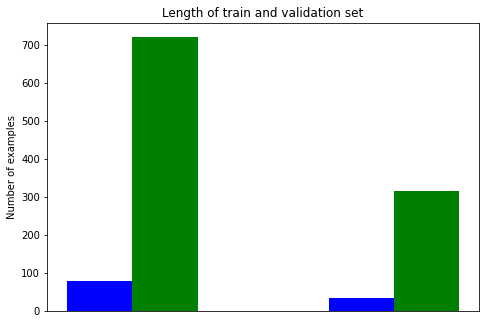

In [12]:
fig = plt.figure()
X = np.arange(1)
ax = fig.add_axes([0,0,1,1])
ax.bar(1.00, valid_positive_examples , color = 'b', width = 0.25)
ax.bar(1.25, valid_negative_examples , color = 'g', width = 0.25)

ax.bar(0.00, positive_examples , color = 'b', width = 0.25)
ax.bar(0.25, negative_examples , color = 'g', width = 0.25)
ax.set_ylabel('Number of examples')
ax.set_title('Length of train and validation set')
# ax.set_xticks((1, 2), ('Train set', 'Validation set'))
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
# fig.show()

### Objective is to classify if a compound with certain features could be active or inactive. We do this by using basic classifier,or ensemble classifiers which are widely used today.

Some of the classifiers are:
- Logistic Regression: We have to test a linear model before testing complex models.
- Bernoulli Naive Bayes classifier: BernoulliNB is designed for binary/boolean features.
- Decision Tree classifier(s): Most effective classifiers.
- Support vector machine's classification algorithm.

```python
X_train, Y_train
X_valid, Y_valid
```

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

lr = LogisticRegression()
clf_lr = lr.fit(X_train, Y_train)
lr_acc = clf_lr.score(X_valid, Y_valid)
print(f"Logistic Regression accuracy: {round(lr_acc*100, 2) }%")

bnb = BernoulliNB()
clf_bnb = bnb.fit(X_train, Y_train)
bnb_acc = clf_bnb.score(X_valid, Y_valid)
print(f"Bernoulli Naive Bayes accuracy: {round(bnb_acc*100, 2)}%")

rf = RandomForestClassifier(max_depth=100, random_state=0)
clf_rf = rf.fit(X_train, Y_train)
rf_acc = clf_rf.score(X_valid, Y_valid)
print(f"Random Forest accuracy: {round(rf_acc*100, 2)}%")

ab = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ab = ab.fit(X_train, Y_train)
ab_acc = clf_ab.score(X_valid, Y_valid)
print(f"AdaBoost accuracy: {round(ab_acc*100, 2)}%")

svc = SVC(gamma='auto')
clf_svc = svc.fit(X_train, Y_train)
svc_acc = clf_svc.score(X_valid, Y_valid)
print(f"Support vector classification accuracy: {round(svc_acc*100, 2)}%")

Logistic Regression accuracy: 92.29%
Bernoulli Naive Bayes accuracy: 89.43%
Random Forest accuracy: 94.0%
AdaBoost accuracy: 92.57%
Support vector classification accuracy: 90.29%


### Reiterating for optimization

Before training the model, we need to select the sampling strategy for accuracy of our model. Since our data is unbalanced, a random sampling technique doesn't seem like an optimal idea. Hence, we need a better strategy. 

####  Stratified Sampling:

Let's say our dataset size is 80, and we have two classes (0 and 1). 80% belongs to class 0, and 20% belongs to class 1.

In stratified sampling, The training_set consists of 64 negative class{0} ( 80% 0f 80 ) and 16 positive class {1} ( 80% of 20 ) i.e. 64{0}+16{1}=80 samples in training_set which represents the original dataset in equal proportion and similarly test_set consists of 16 negative class {0} ( 20% of 80 ) and 4 positive class{1} ( 20% of 20 ) i.e. 16{0}+4{1}=20 samples in test_set which also represents the entire dataset in equal proportion.This type of train-test-split results in good accuracy.

In [14]:
from sklearn.model_selection import StratifiedKFold
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

X_all, Y_all = np.concatenate((X_train, X_valid)), np.concatenate((Y_train, Y_valid))
for i, (train_index, test_index) in enumerate(skf.split(X_all, Y_all)):
    x_train_fold, x_test_fold = X_all[train_index], X_all[test_index]
    y_train_fold, y_test_fold = Y_all[train_index], Y_all[test_index]
    rf.fit(x_train_fold, y_train_fold)
    print(f"Accuracy at {i} iteration: {round(rf.score(x_test_fold, y_test_fold)*100, 2 )}")

Accuracy at 0 iteration: 94.35
Accuracy at 1 iteration: 95.22
Accuracy at 2 iteration: 93.91
Accuracy at 3 iteration: 93.48
Accuracy at 4 iteration: 92.17


## Hyperparameter tuning

Until now we have trained model with fixed number of etimators. We want to test how one model fits our data with different estimators. Before selecting our Hyperparameter, we need to understand what are our metrics we want to improve.
Since we are dealing with imbalanced dataset, we have to make sure our recall is as high as possible.

```python
GridSearchCV(our_classifier, grid_of_parameters, type_of_cross_validation)
    For integer/None inputs, if the estimator is a classifier and ``y`` is either binary or multiclass, :class:`StratifiedKFold` is used. In all
    other cases, :class:`KFold` is used.
```


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [10, 100, 200, 300], 'min_samples_split': [2, 5, 10]}

base_estimator = RandomForestClassifier(random_state=0)
sh = GridSearchCV(base_estimator, param_grid, cv=10, scoring="recall", )

my_fit = sh.fit(X_all, Y_all)
best_parameters = my_fit.best_params_
print(best_parameters)

{'max_depth': 100, 'min_samples_split': 2}


## Confusion Matrix

#### Now that we've got our best model, we can train create our new classifieer and get accuracy, precision and recall on our validation set.

Random Forest accuracy: 94.0%


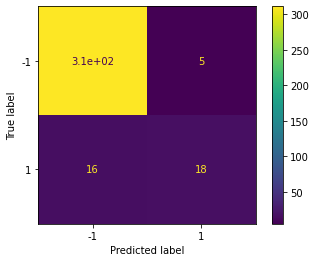

In [18]:
from sklearn.metrics import plot_confusion_matrix
rf = RandomForestClassifier(max_depth=best_parameters['max_depth'], min_samples_split=best_parameters["min_samples_split"], random_state=0)
clf_rf = rf.fit(X_train, Y_train)
rf_acc = clf_rf.score(X_valid, Y_valid)
print(f"Random Forest accuracy: {round(rf_acc*100, 2)}%")
plot_confusion_matrix(clf_rf, X_valid, Y_valid)
plt.show()

In [29]:
from sklearn import metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])